# GPSO basic optimisation example

This notebook showcases the basic example of optimisation using the Gaussian Processes surrogate optimisation package. The method is described in Hadida et al. and reading the paper is recommended in order to grasp what is happening.

**Reference:**
Hadida, J., Sotiropoulos, S. N., Abeysuriya, R. G., Woolrich, M. W., & Jbabdi, S. (2018). Bayesian Optimisation of Large-Scale Biophysical Networks. *NeuroImage*, 174, 219-236.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import logging

from gpso import ParameterSpace, GPSOptimiser
from gpso.plotting import (
    plot_parameter_marginal_distributions,
    plot_conditional_surrogate_distributions,
    plot_ternary_tree,
)
from gpso.utils import set_logger
from gpflow.utilities import print_summary

plt.style.use("seaborn-poster")

First we define the objective function we would like to optimise. Note that this example is the same as in the original paper that introduced the GPSO method.

In [2]:
# define objective function - compare with paper Fig. 2
def obj(point, offset=0.0, rotate=True):
    x, y = point
    if rotate:
        ct = np.cos(np.pi / 4)
        st = np.sin(np.pi / 4)
        xn = ct * x + st * y
        yn = ct * y - st * x
        x = xn
        y = yn
    return (
        3 * (1 - x) ** 2.0 * np.exp(-(x ** 2) - (y + 1) ** 2)
        - 10 * (x / 5.0 - x ** 3 - y ** 5) * np.exp(-(x ** 2) - y ** 2)
        - 1 / 3 * np.exp(-((x + 1) ** 2) - y ** 2)
        - offset
    )


# bounds of the parameters we will optimise
x_bounds = [-3, 5]
y_bounds = [-3, 3]
# number of points per dimension for plotting
N_POINTS = 120

First we will plot the true objective function with its maximum point so we get ourselves familiar with the problem we want to optimise.

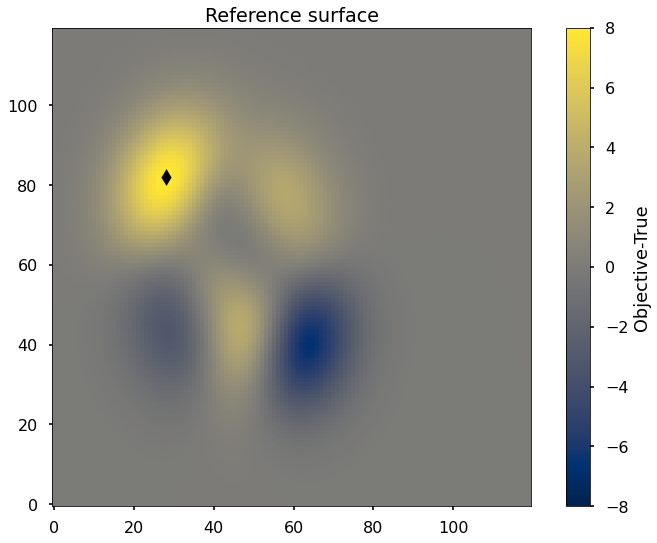

In [3]:
# true objective - reference surface
x = np.linspace(x_bounds[0], x_bounds[1], N_POINTS)
y = np.linspace(y_bounds[0], y_bounds[1], N_POINTS)
x, y = np.meshgrid(x, y)
o = obj([x, y], rotate=True)
plt.imshow(o, vmax=8.0, vmin=-8.0, cmap=plt.get_cmap("cividis"), origin="lower")
cbar = plt.colorbar()
i, j = np.unravel_index(o.argmax(), o.shape)
plt.scatter(j, i, marker="d", color="black")
cbar.set_label("Objective-True")
_ = plt.title("Reference surface")

Now the party begins.

## The party

### Parameter Space
First we will initialise parameter space by calling `ParameterSpace` object which takes two arguments: parameter names as a list and parameter bounds as a list of lists or tuples. The order must agree, i.e. first parameter in names will have bounds as first tuple in the bounds argument.

The `ParameterSpace` object initialises optimisation space, set-up normalisation (GP surrogate works with normalised coordinates between 0-1) and initialises ternary tree for partitioning with root leaf.

In [4]:
space = ParameterSpace(
    parameter_names=["x", "y"], parameter_bounds=[x_bounds, y_bounds]
)

### Optimiser

The main guest our party is, obviously, the optimiser itself. Since we want to make him comfortable, we offer number of user-defined arguments. Please note, that the defaults are very sensible, if you are not sure, what you are doing, just keep them at their default parameters.

#### Arguments:
* `parameter_space`: parameter space to explore, which we initialisd in the previous step; the only required parameter
* `exploration_method`: method used for exploration of child leaves intervals; "tree" for growing tree up to `exploration_depth` and predicting at the center of each leaf, or "sample" for uniform sampling within the leaf's region; in both methods the best sample is recorded and represents the current leaf's score
* `exploration_depth`: depth of the exploration step, for "tree" method it is a depth to which the particular leaf is grown, for "sample" is this number multiplied by number of parameters (i.e. dimensionality of the optimisation problem) squared and this many samples are taken in each exploration steps
* `budget`: budget for the `stopping_condition`, i.e. how many iterations, evaluations of objective function, or up to which depth is the partition tree grown
* `stopping_condition`: to what stopping condition the `budget` refers to: either "evaluations" (algorithm stops after this many objective function evaluations), "iterations" (algorithms stops after this many iterations), or "depth" (algorithm stops after partition tree is grown to this depth)
* `update_cycle`: how often (in iterations) to update the GPR hyperparameters
* `varsigma`: expected probability that upper confidence bound (UCB) < f; it controls how "optimistic" we are during the exploration step; at a point x evaluated using GP, the UCB will be: $\mathrm{UCB} = \mu(x) + \varsigma\cdot\sigma(x)$; $\varsigma = \mathrm{erfc}^{-1}(p/100)$ which corresponds to the upper bound of a $p$ confidence interval for Gaussian likelihood kernel
* `gp_lik_sigma`: initial standard deviation of Gaussian likelihood function (in normalised units)
* `n_workers`: number of workers to use where applicable (e.g. during initialisation or multiple objective function evaluations)
* `callbacks`: list of callbacks or None - more about that in `1-callbacks.ipynb`!
* `saver`: optional saver for results from objective function, as sometimes it is useful to track the output of the model, not just its score which we are maximising - more about saver in `2-saving-model-output.ipynb`!
* possible keyword arguments:
    * `gp_kernel`: covariance kernel for GPR, Matern52 by default
    * `gp_kernel_ARD`: whether to use ARD for lengthscales in the GPR kernel, by default False (usually worse, but for large dimensions might help)
    * `gp_meanf`: mean function for GPR, constant by default
    * `gp_mu`: initial value for constant mean function in GPR, 0.0 by default
    * `gp_length`: initial value for lengthscales in the kernel function in GPR, 0.25 by default (in normalised coordinates!)
    * `gp_var`: initial value for variance in the kernel function in GPR, 1.0 by default

In [5]:
opt = GPSOptimiser(
    parameter_space=space,
    exploration_method="tree",
    exploration_depth=5,
    update_cycle=1,
    budget=50,
    stopping_condition="evaluations",
    gp_lik_sigma=1.0e-3,
    n_workers=4,
)

### Run

Finally run the optimisation! Fortunately, now running the optimisation is easy! Just call the `run` method of the `GPSOptimiser` instance. This method take two arguments:
* `objective_function`: this is obvious, the actual objective function we want to optimise for; must be callable and take un-normalised parameters as an argument and output scalar score (see example objective function in this notebook)
* `init_samples`: specify how to deal with initialisation of the optimisation problem; default is to evaluate two vertices per dimension, equally spaced from the center (i.e. within L1 ball of 0.25 of the domain size radius), or user can specify at which coordinates we should initialise
* `eval_repeats`: number of repetitions for objective evaluation function when it is stochastic and some statistics on the score is necessary; repeats are not counted towards the budget of objective evaluations; multiprocessing is used when n_workers > 1; 1 by default
* `eval_repeats_function`: function for aggregating multiple evaluations (see `eval_repeats`), has to take axis as an argument, good choices are mean, median or max; their nan-version can be used as well, when the stochastic evaluation might expectedly fail; mean by default

In [6]:
# log_level INFO: reasonable amount of information on what is happening
# log_level DEBUG: a lot of information on what is happening
set_logger(log_level=logging.INFO)
# run vanilla, with default initialisation and just 1 repetition of objective function (since it's deterministic...)
best_point = opt.run(obj)

[2020-03-31 16:57:05] INFO: Starting 2-dimensional optimisation with budget of 50 objective function evaluations...
[2020-03-31 16:57:05] INFO: Sampling 2 vertices per dimension within L1 ball of 0.25 of the domain size radius in normalised coordinates using 4 worker(s)...
[2020-03-31 16:57:05] INFO: Update step: retraining GP model and updating scores...
[2020-03-31 16:57:07] INFO: Exploration step: sampling children in the ternary tree...
[2020-03-31 16:57:08] INFO: Selecting step: evaluating best leaves...
[2020-03-31 16:57:08] INFO: Update step: retraining GP model and updating scores...
[2020-03-31 16:57:08] INFO: After 1th iteration: 
	 number of obj. func. evaluations: 6 
	 highest score: 2.019346080880167 
	 highest UCB: 0.5464137300580307
[2020-03-31 16:57:08] INFO: Exploration step: sampling children in the ternary tree...
[2020-03-31 16:57:08] INFO: Selecting step: evaluating best leaves...
[2020-03-31 16:57:08] INFO: Update step: retraining GP model and updating scores...
[

In [7]:
# WOHOOO, check the best point
print(best_point)
# and print summary of our trained GPR model
print_summary(opt.gp_surr.gpr_model, fmt="notebook")

GPPoint(normed_coord=array([0.23662551, 0.68518519]), score_mu=8.102201204076508, score_sigma=0.0, score_ucb=0.0, label=<PointLabels.evaluated: 1>)


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,,,True,(),float64,0.1914997630083578
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.1638359516958254
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[0.12871433]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0482615988850796e-06


### Afterparty

OK, optimiser told us we are done, let's check.

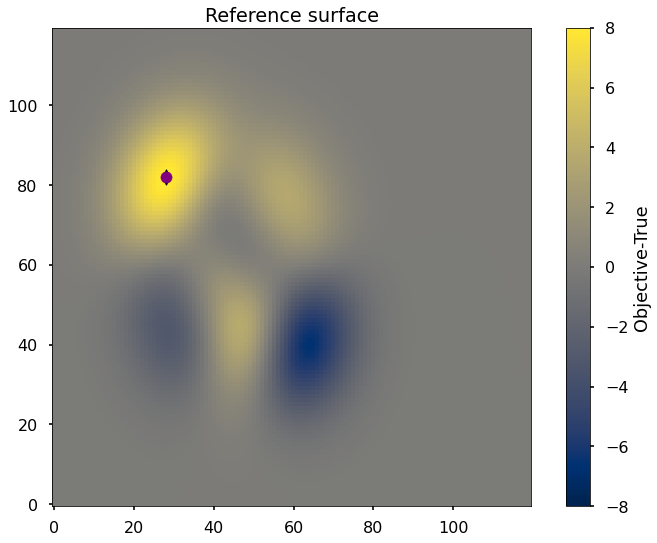

In [8]:
# first, just draw coordinates of the "best point" as returned by optimiser to the reference surface
plt.imshow(o, vmax=8.0, vmin=-8.0, cmap=plt.get_cmap("cividis"), origin="lower")
cbar = plt.colorbar()
i, j = np.unravel_index(o.argmax(), o.shape)
plt.scatter(j, i, marker="d", color="black")
ii, jj = best_point.normed_coord
plt.scatter(
    int(np.around(ii * N_POINTS)),
    int(np.around(jj * N_POINTS)),
    marker="o",
    color="purple",
)
cbar.set_label("Objective-True")
_ = plt.title("Reference surface")

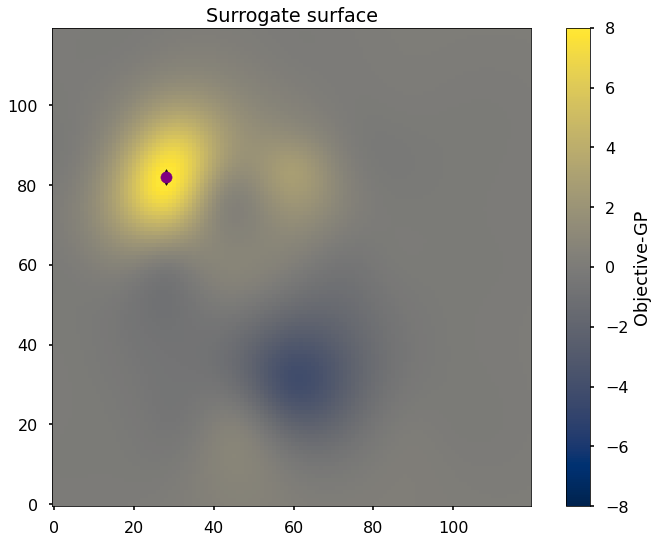

In [9]:
# interested how the surrogate surface actually looks like?
stk = np.hstack([x.reshape((-1, 1)), y.reshape((-1, 1))])
mean, var = opt.gp_surr.gpr_model.predict_y(opt.param_space.normalise_coords(stk))
mean = mean.numpy().reshape(x.shape)
var = var.numpy().reshape(x.shape)
plt.imshow(mean, vmax=8.0, vmin=-8.0, cmap=plt.get_cmap("cividis"), origin="lower")
cbar = plt.colorbar()
i, j = np.unravel_index(o.argmax(), o.shape)
plt.scatter(j, i, marker="d", color="black")
ii, jj = best_point.normed_coord
plt.scatter(
    int(np.around(ii * N_POINTS)),
    int(np.around(jj * N_POINTS)),
    marker="o",
    color="purple",
)
cbar.set_label("Objective-GP")
_ = plt.title("Surrogate surface")

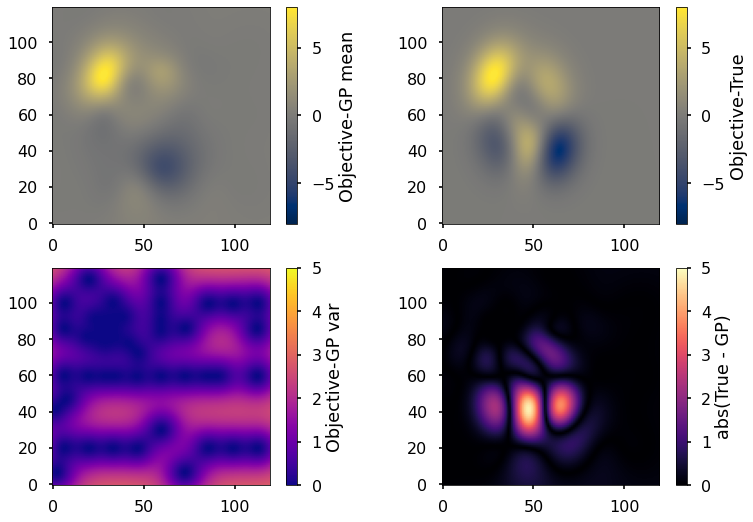

In [10]:
# now compare true objective function with a surrogate that was learnt by the GPR
plt.subplot(2, 2, 1)
plt.imshow(mean, vmax=8.0, vmin=-8.0, cmap=plt.get_cmap("cividis"), origin="lower")
cbar = plt.colorbar()
cbar.set_label("Objective-GP mean")
plt.subplot(2, 2, 3)
plt.imshow(var, vmax=5.0, vmin=0.0, cmap=plt.get_cmap("plasma"), origin="lower")
cbar = plt.colorbar()
cbar.set_label("Objective-GP var")

plt.subplot(2, 2, 2)
plt.imshow(o, vmax=8.0, vmin=-8.0, cmap=plt.get_cmap("cividis"), origin="lower")
cbar = plt.colorbar()
cbar.set_label("Objective-True")
plt.subplot(2, 2, 4)
plt.imshow(
    np.abs(o - mean), vmax=5.0, vmin=0, cmap=plt.get_cmap("magma"), origin="lower"
)
cbar = plt.colorbar()
cbar.set_label("abs(True - GP)")

`GPSO` package itself contain some useful plotting methods.

First is a look at the marginal distribution of the parameters. The method gathers all evaluated points, sorts them according to their score, selects $p$th percentile (50th in this example) and plots distribution of the values, either a kernel density estimate (`plot_type="kde"`) or histogram (`plot_type="hist"`).

As we see from the plot, `x` around -1 and `y` around 1 lead to high score of the objective function.

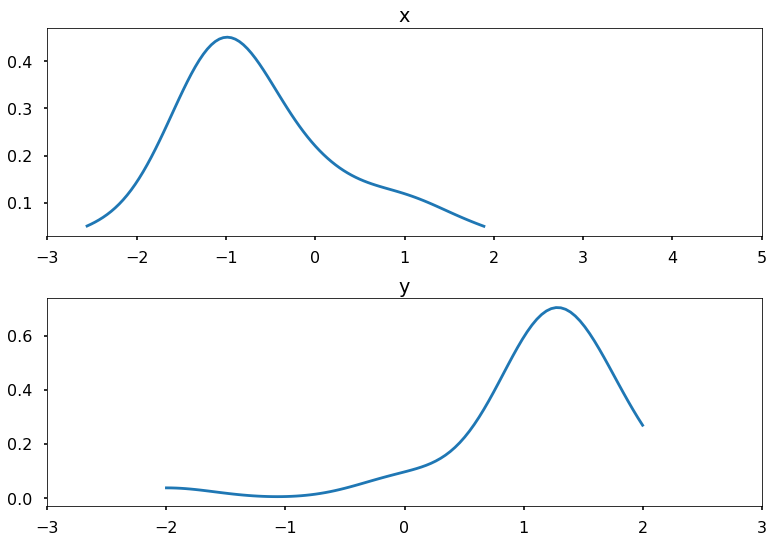

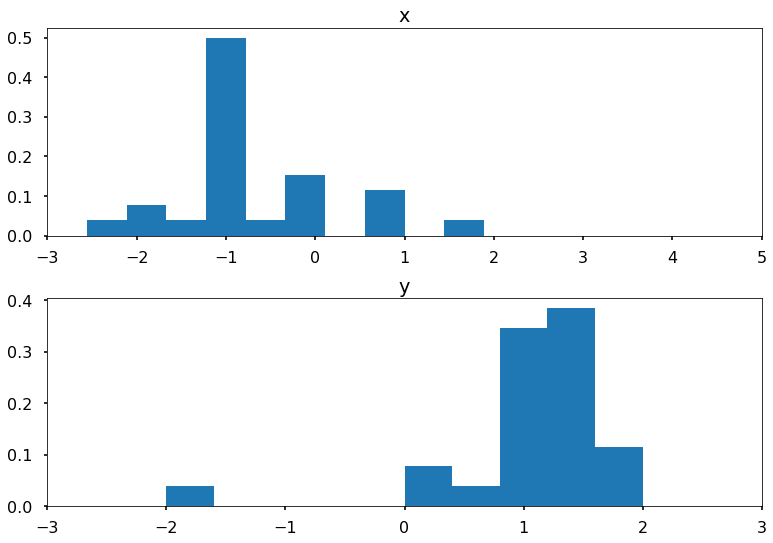

In [11]:
plot_parameter_marginal_distributions(opt, percentile=0.5, plot_type="kde")
plot_parameter_marginal_distributions(opt, percentile=0.5, plot_type="hist")

Another useful look at the data is to visualise the conditional surrogate distribution. This is easy in 2D (i.e. for optimisation of 2 parameters) - we already did it by hand. However, for more-than-2-D problems it becomes more challenges. `GPSO` offers `plot_conditional_surrogate_distributions` to the rescue.

The resulting plot contains $n^{2}$ ($n$ being the number of optimised parameters) subplots arranged into a square - lower triangle contains conditional surrogate mean of a pair of parameters, upper triangle contains conditional surrogate variance, and the diagonal just states the mean and variance of scores from points evaluated within those parameter ranges.

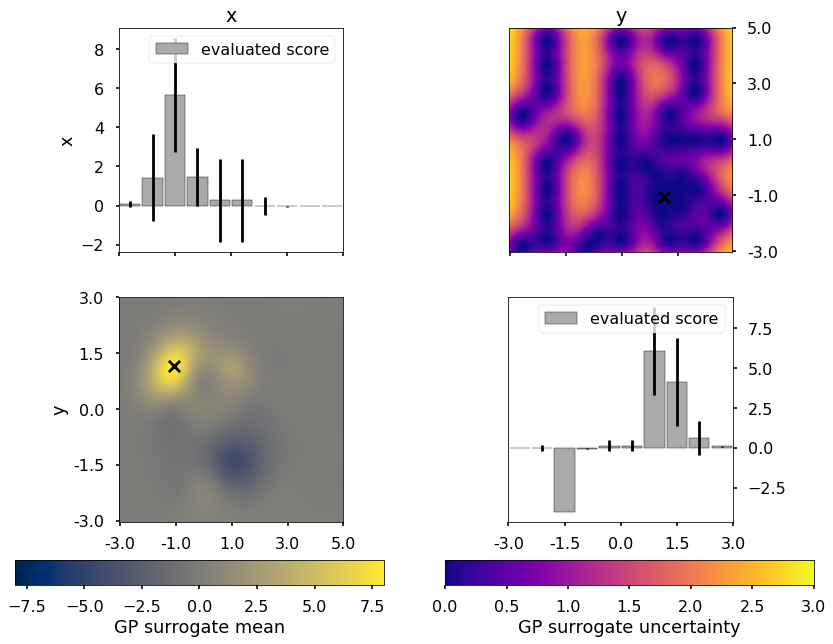

In [12]:
plot_conditional_surrogate_distributions(
    opt, mean_limits=(-8, 8), var_limits=(0, 3), mean_cmap="cividis", var_cmap="plasma"
)

Finally, `GPSO` offers a view of the ternary tree: larger nodes with black edge represent leaves at whose center the objective function was evaluated, while the smaller nodes without an edge represent leaves that were only estimated using the surrogate.

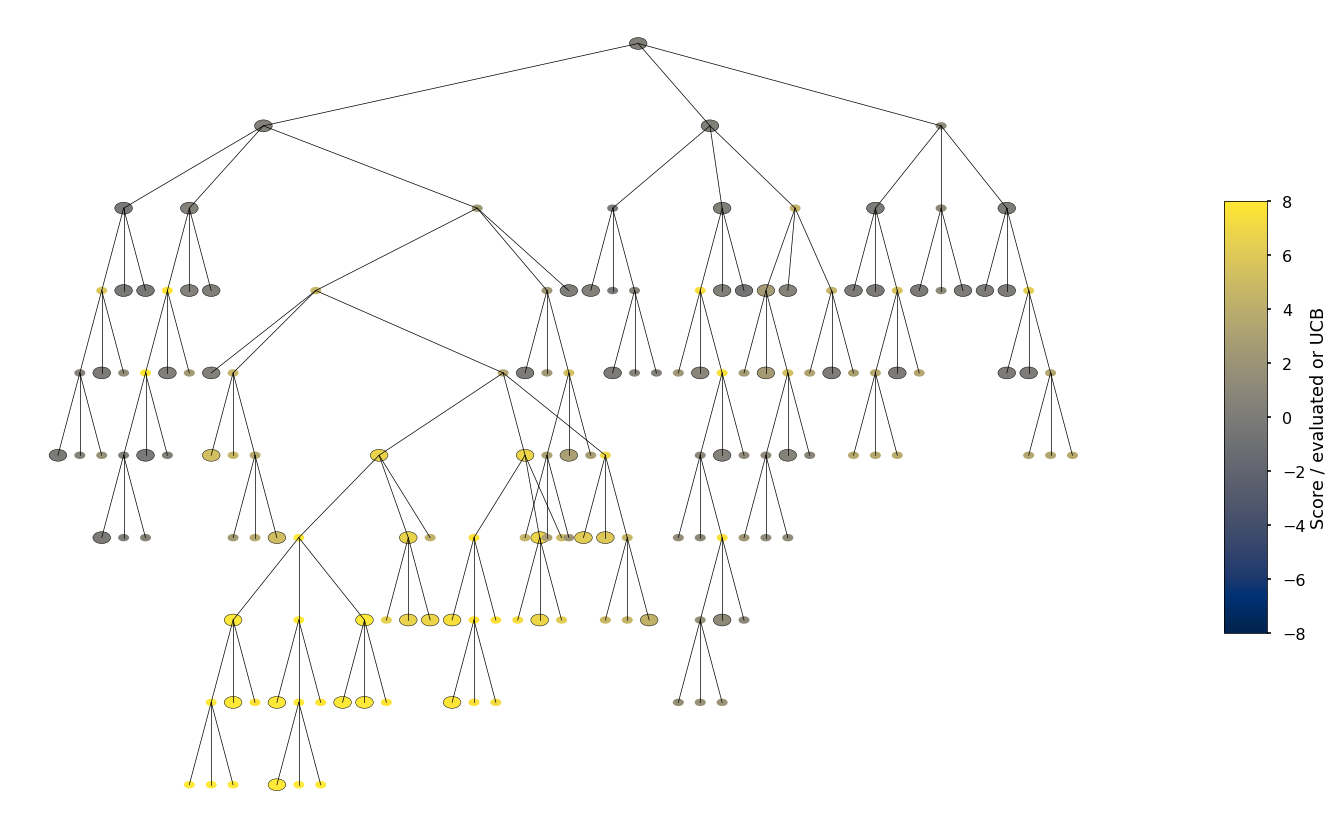

In [13]:
# plotting tree requires python-igraph package
plot_ternary_tree(
    opt.param_space,
    cmap="cividis",
    figsize=(20, 15),
    center_root_node=True,
    cmap_limits=[-8, 8],
)